# **Malaria Infected Cells: Detection and Classification**

*Fábio Chacon (April 2020)*



---

In this notebook, we are going to train a convolutional neural network to detect malaria parasites in cells, and classify images of uninfected and infected cells, with the following steps: firts, infected cells images are converted to the [LAB color space](https://en.wikipedia.org/wiki/CIELAB_color_space). By doing this, the red pathological structures, present in infected cells, turn green. Next, we get the coordinates corresponding to the maximum pixel value on the green channel of each infected cell image, and a bounding box is created surrounding the pathological point. A CNN regressor is trained in order to detect and predict new bounding boxes for the test data. With this trained network, we extract features from infected and uninfected cells (from a separate set of images). Finally, using the features, we train a xgboost classifier to classify the images. We also train and test the classifier for the imbalanced class scenario, where uninfected cells images are the majority class.

&nbsp;

In [0]:
# Importing required packages

# tf.keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Sklearn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

# XGBoost import
from xgboost import XGBClassifier

# import for showing the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

# Imports for image manipulation
import cv2
from skimage.feature import peak_local_max
from skimage.io import imread, imshow
from PIL import Image

# Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib import patches

# Numpy and Seaborn imports
import numpy as np
import seaborn as sns

# Other imports
from os.path import join
import os
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [0]:
# Read and load the images as numpy arrays

IMAGE_SHAPE = (100, 100, 3)

dir_path = '.../cell_images/'

infected_path = [join(dir_path, 'Parasitized', filename) 
for filename in os.listdir(join(dir_path, "Parasitized")) if '.png' in filename]
uninfected_path = [join(dir_path, 'Uninfected', filename) 
for filename in os.listdir(join(dir_path, "Uninfected")) if '.png' in filename]

infected, uninfected, target = [], [], []
for filename in infected_path:
    image = imread(filename)
    if image.ndim==2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, IMAGE_SHAPE[:2])
    infected.append(image)
    target.append(to_categorical(1, num_classes=2))
    
for filename in uninfected_path:
    image = imread(filename)
    if image.ndim==2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, IMAGE_SHAPE[:2])
    uninfected.append(image)
    target.append(to_categorical(0, num_classes=2))


## About the Dataset

The dataset contains a total of 27,558 cell images with equal instances of infected and uninfected cells.


In [0]:
# Load the data
X = np.load('/content/drive/My Drive/data/data_imgs.npy')
y_true = np.load('/content/drive/My Drive/data/true.npy')

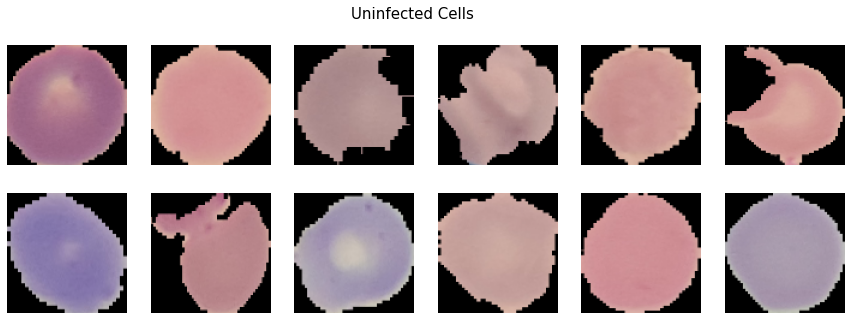

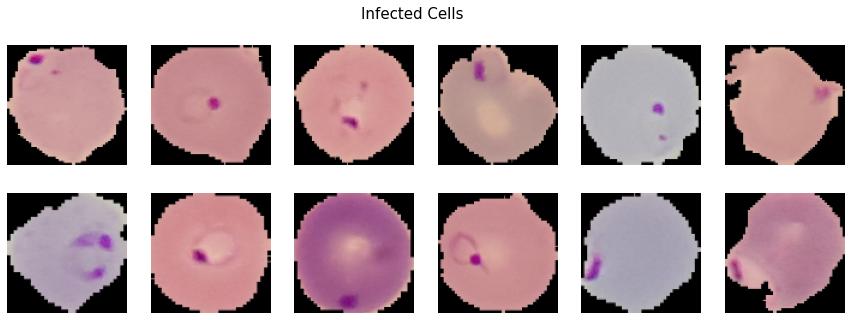

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X[y_true[:, 1]==0], rows=2, cols=6, title='Uninfected Cells')
visualize_samples(X[y_true[:, 1]==1], rows=2, cols=6, title='Infected Cells')

---
## *Steps:*


1. Convert infected cells images to LAB color space
2. Get the point for the maximum pixel value on the green channel.
3. Using the points, generate bounding boxes.
4. Define a generator to augment the train data.
5. Define a model.
5. Train and predict new bounding boxes for the test data.
6. Using a separate set of images, extract features from both classes of cells.
7. Train a XGboost on balance classes and evaluate the model.
8. Train XGboost on unbalanced classes and evaluate using the appropriate metrics.
---

&nbsp;


## Converting infected cells images to LAB color space

In [0]:
# Load images of infected cells
infected = X[y_true[:, 1]==1]

# Convert the infected cells images to Lab color space
images_lab = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2LAB) for image in infected])

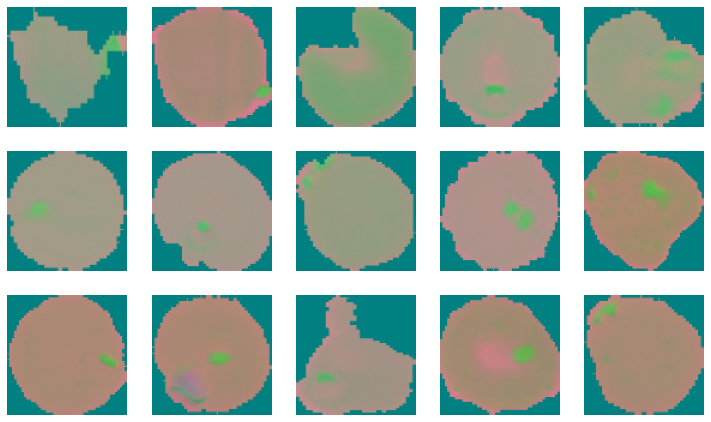

In [0]:
visualize_samples(images_lab, cols=5, rows=3)

## Getting the coordinates for the maximum pixel value on the green channel

In [0]:
# Peak local maximum on the green channel
local_max = np.array([peak_local_max(image[..., 1], num_peaks=1).flatten() for image in images_lab])

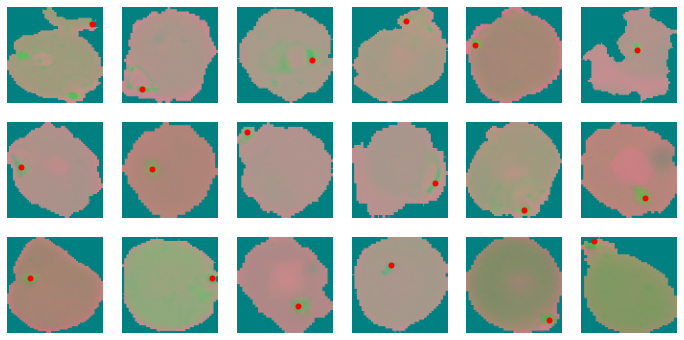

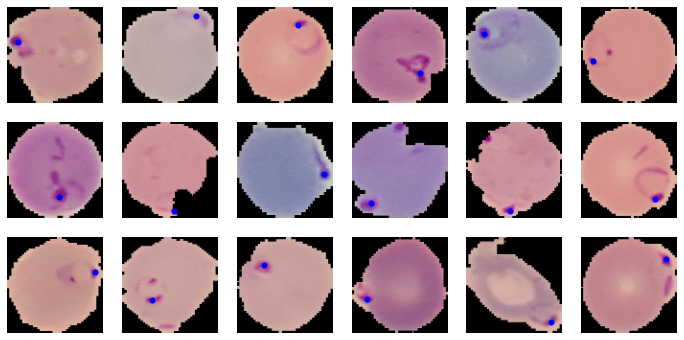

In [0]:
def visualize_peaks(images, points, rows=1, cols=5, color='r', size=25):
    plt.figure(figsize = (2*cols, 2*rows))
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, (image, point) in enumerate(zip(images[idx], points[idx])):
        plt.subplot(rows, cols, i+1)
        plt.scatter(x=point[1], y=point[0], color=color, s=size)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

visualize_peaks(images_lab, local_max, rows=3, cols=6)
visualize_peaks(infected, local_max, rows=3, cols=6, color='b')


## Generating Bounding Boxes

In [0]:
def generate_bboxes(points, offset=18):
    if points.ndim==1:
        min_row = points[0] - offset
        min_col = points[1] - offset
        max_row = points[0] + offset
        max_col = points[1] + offset
        bbox = np.array([min_row, min_col, max_row, max_col])
        return bbox
    else:
        bboxes = []
        for box_id, point in enumerate(points):
            min_row = point[0] - offset
            min_col = point[1] - offset
            max_row = point[0] + offset
            max_col = point[1] + offset
            bboxes.append([box_id, min_row, min_col, max_row, max_col])
        return np.array(bboxes)
bboxes = generate_bboxes(local_max)

In [ ]:
def visualize_bboxes(images, 
                     pred_bboxes=None, 
                     original_bboxes=None, 
                     cols=5, rows=3):
      """
      This function displays bounding boxes.
      """
    
    plt.figure(figsize = (3*cols, 3*rows))
    for n, idx in enumerate(np.random.choice(range(len(images)), size=cols * rows)):
        ax = plt.subplot(rows, cols, n+1)
        plt.axis('off')
        plt.imshow(images[idx])
        if pred_bboxes is not None:
            show_bboxes(bboxes=pred_bboxes[pred_bboxes[:, 0]==idx, 1:], ax=ax, color="blue")
        if original_bboxes is not None:
            show_bboxes(bboxes=original_bboxes[original_bboxes[:, 0]==idx, 1:], ax=ax, color="red")
    plt.show()

def show_bboxes(bboxes, ax, color="black"):
    for i, bbox in enumerate(bboxes):
        ax.add_patch(patches.Rectangle((bbox[1], bbox[0]), 
                                       bbox[3] - bbox[1], bbox[2] - bbox[0], 
                                       fill=False, color=color, lw=1.5))

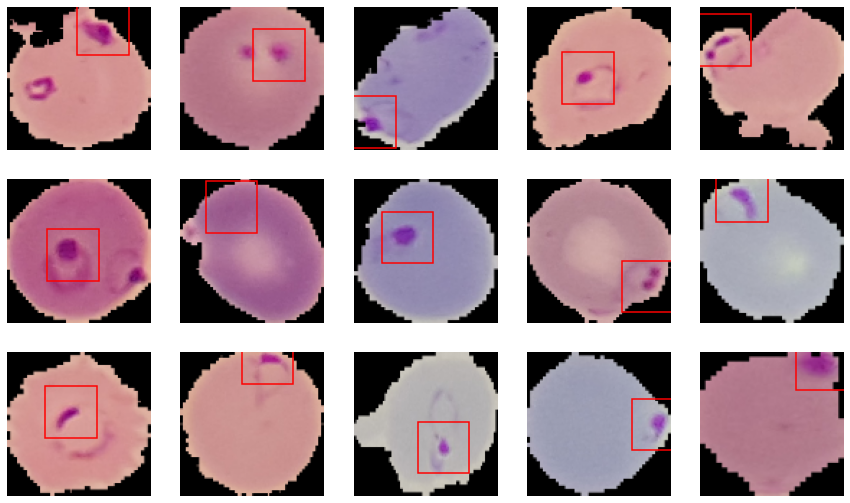

In [0]:
visualize_bboxes(images=infected, original_bboxes=bboxes, cols=5, rows=3)



## Data Augmentation


Data augmentation is an important step in a deep learning pipeline. Deep learning algorithms achieves better generalization performance when more data is used. In our particar case, the augmentation consists of applying left/right and up/down flips to the images. Since the points are needed in order to generate bounding boxes, they must be flipped as well. To achieve this, we take the dot product between the point and a rotation matrix.

In [0]:
IMAGE_SHAPE = (100, 100, 3)

scaler = MinMaxScaler()

def flip_lr_ud(img, 
               point, 
               flip_type=None):
    if flip_type is not None:
        if flip_type=="ud":
          R = np.array([[0, -1], [1, 0]]) # 90° Rotation Matrix
          image = img[::-1]
        elif flip_type=='lr':
          R = np.array([[0, 1], [-1, 0]]) # 270° Rotation Matrix
          image = np.fliplr(img)
    point = point / img.shape[0] - .5
    flipped_point = R.dot(point[::-1])
    flipped_point = np.clip(np.asarray((flipped_point+0.5)*img.shape[0], 
                                       dtype=np.int32), 0, img.shape[0]-5)
    return image, flipped_point

    
def datagen(data, label, batch_size):
     
     """
     This function defines a data generator.
     """
    
    data_len = len(data)
    steps = data_len // batch_size
    new_batch = np.zeros(((batch_size,)+IMAGE_SHAPE), dtype=np.float32)
    batch_bboxes = np.zeros((batch_size, 4))
    i = 0
    indices = np.arange(data_len)
    
    while True:
        np.random.shuffle(indices)
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        index = 0
        for idx in next_batch:
            image = data[idx]
            point = label[idx]
            new_batch[index] = image
            bbox = generate_bboxes(point)
            batch_bboxes[index] = bbox
            if index < batch_size-2:
                img_lr, point_lr = flip_lr_ud(image, point, 'lr')
                img_ud, point_ud = flip_lr_ud(image, point, 'ud') 
                bbox_lr = generate_bboxes(point_lr)
                bbox_ud = generate_bboxes(point_ud)   
                new_batch[index+1] = img_lr
                batch_bboxes[index+1] = bbox_lr
                new_batch[index+2] = img_ud
                batch_bboxes[index+2] = bbox_ud
                index += 1
            if index==batch_size-1:
                break
        i+=1
        yield new_batch, scaler.fit_transform(batch_bboxes)
        if i >= steps:
            i=0

In [0]:
def visualize_peak_flipped(image, 
                           image_lr_ud, 
                           points,
                           points_lr_ud, color='r'):
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].scatter(x=points[1], y=points[0], color=color, s=30)
    ax[1].imshow(image_lr_ud)
    ax[1].scatter(x=points_lr_ud[1], y=points_lr_ud[0], color=color, s=30)
    plt.axis('off')
    plt.show()

&nbsp;

We show an example of what the augmentation processes will be doing during  training.

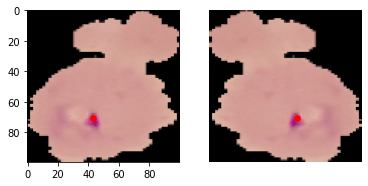

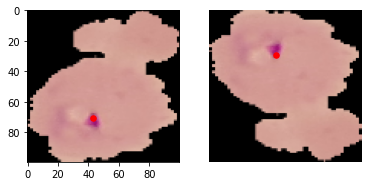

In [0]:
img = infected[1]
point = local_max[1]
img_lr, point_lr = flip_lr_ud(img, point, 'lr') 
visualize_peak_flipped(img ,img_lr, point, point_lr)
img_ud, point_ud = flip_lr_ud(img, point, 'ud')
visualize_peak_flipped(img, img_ud, point, point_ud)

In [0]:
"""
Here we split images of infected cells into two equal parts. 
X_cnn corresponds to the set of images that are going to be used 
to train the network and X_cls, to train the classifier. 
"""

X_infected = infected.astype(np.float32) / 255.0
X_cnn, X_cls, y_cnn, _ = train_test_split(X_infected, local_max, test_size=.5, random_state=1)
print("CNN examples: {} | Classifier examples: {}".format(len(X_cnn), len(X_cls)))

CNN examples: 6889 | Classifier examples: 6890


## Preparing the data for the network

In [2]:
"""
We split our data into train, validation and test sets.
We will be using the test set only to predict and display new
bounding boxes. 
"""

X_train, X_, y_train, y_ = train_test_split(X_cnn, y_cnn, test_size=.15, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.05, random_state=1)
y_val = generate_bboxes(y_val)
y_val = scaler.fit_transform(y_val[:, 1:])
print("Train on {} | Validate on {}".format(len(X_train), len(X_val)))
print("Train on 5855 | Validate on 982")

Train on 5855 | Validate on 982


# Network architecture

Our model consists of a CNN regressor with three convolutional layers and one separable convolutional layer. Separable convolutions applies convolution operations for each channel of an input image and uses less parameters than the traditional convolution. There are three fully connected layers at the top of the network. We also use dropout layers between fully connected layers for regularization.

In [0]:
x = inputs = Input(IMAGE_SHAPE)

x = Conv2D(32, (3, 3), activation='relu', name='conv_1')(x)
x = MaxPooling2D(name='pool1')(x)

x = Conv2D(32, (3, 3), activation='relu', name='conv_2')(x)
x = MaxPooling2D(name='pool2')(x)

x = Conv2D(64, (3, 3), activation='relu', name='conv_3')(x)
x = MaxPooling2D(name='pool3')(x)

x = SeparableConv2D(128, (3, 3), activation='relu', name='sepconv_1')(x)
x = MaxPooling2D(name='pool5')(x)

x = Flatten()(x)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(350, activation='relu', name='fc2')(x)
x = Dropout(0.25)(x)
x = Dense(250, activation='relu', name='fc3')(x)
x = Dropout(0.25)(x)

outputs = Dense(4, activation='linear', name='output')(x)

# This creates a model 
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 21, 21, 64)        18496     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 10, 10, 64)        0     

In [0]:
def visualize_results(history) :
    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['mae']
    val_acc = history.history['val_mae']
    epochs = range(1, 1 + len(train_loss)) 

    plt.style.use('seaborn-white')
    ax1.plot(epochs, train_loss, color='blue', label='Train loss')
    ax1.plot(epochs, val_loss, color='orange', label='Valdation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train and Validation Loss')
    ax1.legend()
    ax2.plot(epochs, train_acc, color='blue', label='Train MAE')
    ax2.plot(epochs, val_acc, color='orange', label='Validation MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.set_title('Train and Validation MAE')
    plt.tight_layout()
    plt.show()

# Setting data generator

In [0]:
batch_size = 32
epochs = 30

train_generator = datagen(data=X_train, label=y_train, batch_size=batch_size)
st_per_epoch = X_train.shape[0] // batch_size

# Network Training 

Epoch 1/30
182/182 [==============================] - 2s 11ms/step - loss: 0.0895 - mae: 0.2440 - val_loss: 0.0328 - val_mae: 0.1349
Epoch 2/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0316 - mae: 0.1305 - val_loss: 0.0172 - val_mae: 0.0905
Epoch 3/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0228 - mae: 0.1086 - val_loss: 0.0147 - val_mae: 0.0775
Epoch 4/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0205 - mae: 0.1008 - val_loss: 0.0159 - val_mae: 0.0816
Epoch 5/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0190 - mae: 0.0960 - val_loss: 0.0139 - val_mae: 0.0705
Epoch 6/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0173 - mae: 0.0917 - val_loss: 0.0131 - val_mae: 0.0651
Epoch 7/30
182/182 [==============================] - 2s 10ms/step - loss: 0.0173 - mae: 0.0902 - val_loss: 0.0120 - val_mae: 0.0671
Epoch 8/30
182/182 [==============================] - 2s 10ms/step - 

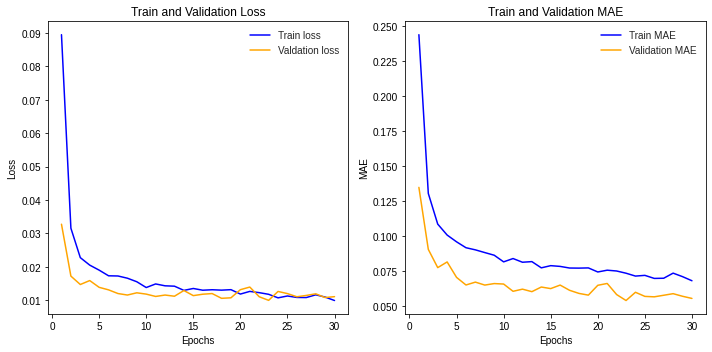

In [0]:
model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae'])

history = model.fit(train_generator,
                    steps_per_epoch=st_per_epoch,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    epochs=epochs)

visualize_results(history)

## Predicting Bounding Boxes

In [0]:
# Predict new bounding boxes
pred_bboxes = model.predict(X_test)
pred_bboxes = scaler.inverse_transform(pred_bboxes).astype(np.int32)
box_id = np.arange(len(pred_bboxes)).reshape(-1, 1)
pred_bboxes = np.hstack([box_id, pred_bboxes])

# Generate bounding boxes for the test data
bboxes_test = generate_bboxes(y_test)

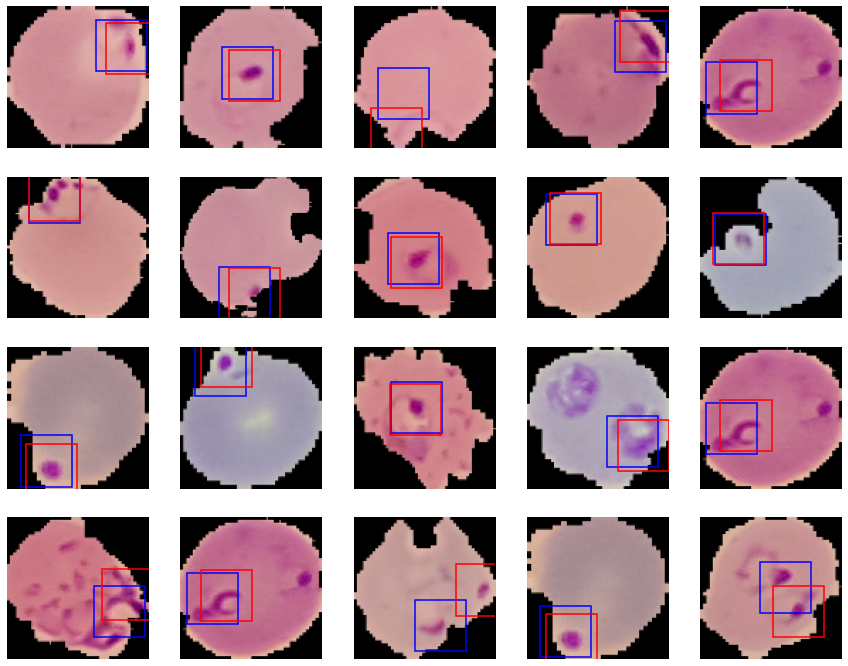

In [0]:
# BLUE BOXES = PREDICTED
# RED BOXES = ORIGINAL

visualize_bboxes(X_test, 
                 original_bboxes=bboxes_test, 
                 pred_bboxes=pred_bboxes,
                 cols=5,
                 rows=4)

#### We can make more predictions using the images separated for the classifier

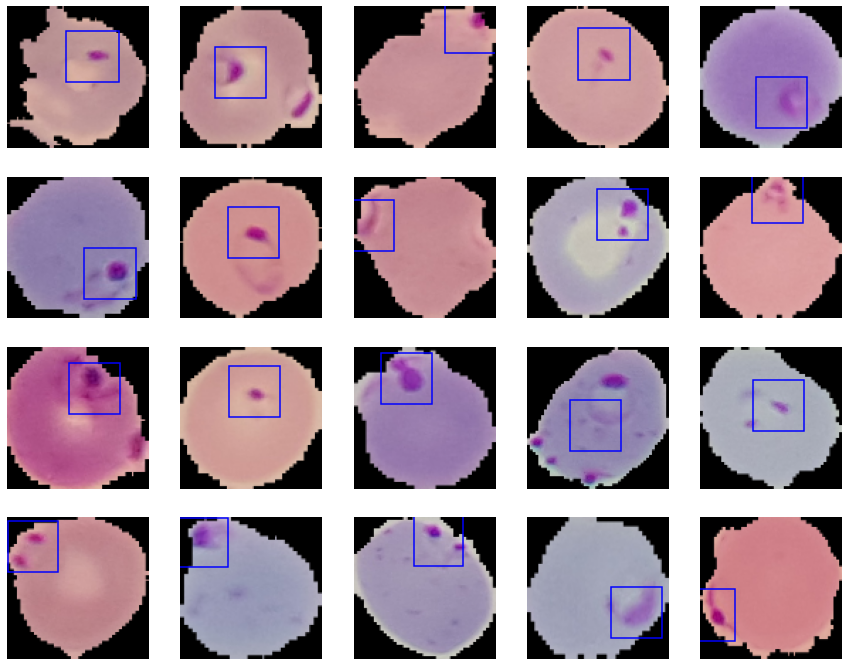

In [0]:
pred_bboxes = model.predict(X_cls)
pred_bboxes = scaler.inverse_transform(pred_bboxes).astype(np.int32)
box_id = np.arange(len(pred_bboxes)).reshape(-1, 1)
pred_bboxes = np.hstack([box_id, pred_bboxes])

visualize_bboxes(X_cls, 
                 pred_bboxes=pred_bboxes,
                 cols=5,
                 rows=4)

&nbsp;

#### **Let's make some predictions on uninfected cells and see what the algorithm detects**

In [0]:
uninfected = X[y_true[:, 1]==0].astype(np.float32) / 255.0
pred_bboxes = model.predict(uninfected)
pred_bboxes = scaler.inverse_transform(pred_bboxes).astype(np.int32)
box_id = np.arange(len(pred_bboxes)).reshape(-1, 1)
pred_bboxes = np.hstack([box_id, pred_bboxes])

visualize_bboxes(uninfected, 
                 pred_bboxes=pred_bboxes,
                 cols=5,
                 rows=5)

I ran the above code a couple of times and saved the outputs. It seems that this dataset comes with some mistakes. If you look carefully, the algorithm has detected strange red blobs in what should be uninfected cells. In particular, the image in the first column, sixth row, is very similar to an infected cell. Perhaps these structures are normal in healthy human cells, but most probably not. Almost all datasets come with mistakes. 

![alt text](https://drive.google.com/uc?id=1DJjnTkcdSMrOlIAzidtqfyqIsAONoYdo)
![alt text](https://drive.google.com/uc?id=1FoFesUwiC6h6pupfwwuWXTKy8Knr9HG3)

## Setting Feature Extractor

In [0]:
outputs = model.get_layer("fc1").output
feature_extractor = Model(model.input, outputs)
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 21, 21, 64)        18496     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 10, 10, 64)        0   

# Preparing the data for the classifier


In [0]:
def get_uninfected(up_sample=0):
    X_uninfected = X[y_true[:, 1]==0][:len(X_cls) + up_sample]
    X_uninfected = X_uninfected.astype(np.float32) / 255
    return X_uninfected

def get_labels():
    class_1 = np.ones((len(X_cls), 1))
    class_0 = np.zeros((len(X_uninfected), 1))
    y_label = np.vstack([class_1, class_0])
    return y_label   

In [0]:
X_uninfected = get_uninfected()
y_label = get_labels()
X_classifier = np.vstack([X_cls, X_uninfected])
print("Number of examples: {}".format(len(X_classifier)))

Number of examples: 13780


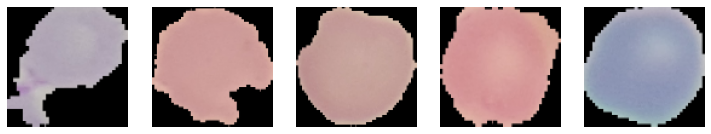

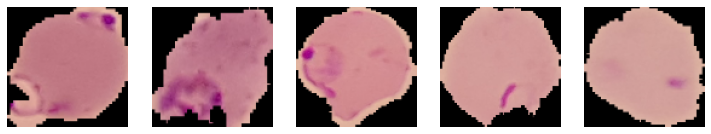

In [0]:
visualize_samples(X_classifier[y_label[:, 0]==0])
visualize_samples(X_classifier[y_label[:, 0]==1])

# Fitting XGBoost Classifier

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_classifier, y_label, test_size=.2, random_state=1)

# Extract features from both training and test sets
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)
print("Train: {} |" "Test: {}".format(train_features.shape, test_features.shape))

Train: (11024, 512) |Test: (2756, 512)


In [0]:
# Fit the classifier
xgboost = XGBClassifier(objective="binary:logistic")
xgboost.fit(train_features, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## *Classifier Evaluation - Balanced Classes*

In [0]:
xgboost_yhat = xgboost.predict(test_features)
print("Test accuaracy %.2f"  % accuracy_score(y_test, xgboost_yhat))

Test accuaracy 0.96


In [0]:
report = classification_report(y_test, xgboost_yhat, target_names=['Uninfected', 'Infected'])
print("\t\t\tClassification Report\n")
print(report)

			Classification Report

              precision    recall  f1-score   support

  Uninfected       0.95      0.97      0.96      1363
    Infected       0.97      0.95      0.96      1393

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



<Figure size 432x288 with 0 Axes>

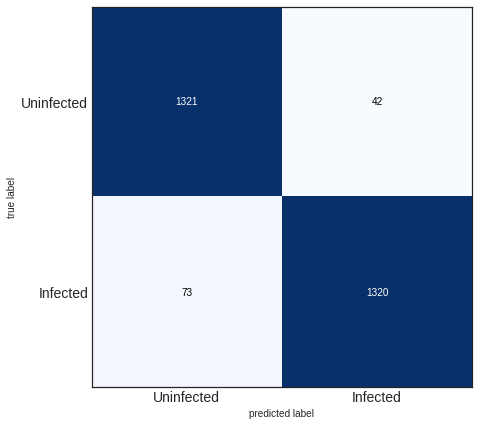

In [0]:
cm  = confusion_matrix(y_test, xgboost_yhat)
plt.figure()
plot_confusion_matrix(cm,figsize=(7, 7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Uninfected', 'Infected'], fontsize=14)
plt.yticks(range(2), ['Uninfected', 'Infected'], fontsize=14)
plt.show()

&nbsp;

## *Fitting and Evaluation - Imbalanced Classes*



In [0]:
X_uninfected = get_uninfected(up_sample=6000)
y_label = get_labels()
X_classifier = np.vstack([X_cls, X_uninfected])
print("Number of examples: {}".format(len(X_classifier)))

Number of examples: 19780


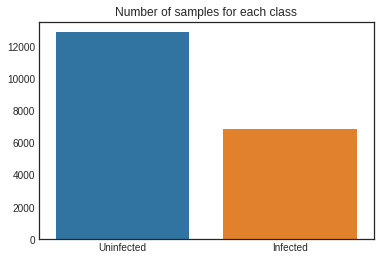

In [0]:
ax = sns.barplot(x=["Uninfected", "Infected"], y=[X_classifier[y_label[:, 0]==0].shape[0], X_classifier[y_label[:, 0]==1].shape[0]])
ax.set_title("Number of samples for each class")
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_classifier, y_label, test_size=.3, random_state=1)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)
print("Train on {} | Test on {}".format(len(train_features), len(test_features)))

Train on 13846 | Test on 5934


In [0]:
# Train the classifier on imbalanced data
xgboost = XGBClassifier(objective="binary:logistic")
xgboost.fit(train_features, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xgboost_yhat = xgboost.predict(test_features)

report = classification_report(y_test, xgboost_yhat, target_names=['Uninfected', 'Infected'])
print("\t\t\tReport - Imbalanced Classes\n")
print(report)

			Report - Imbalanced Classes

              precision    recall  f1-score   support

  Uninfected       0.97      0.97      0.97      3811
    Infected       0.95      0.95      0.95      2123

    accuracy                           0.97      5934
   macro avg       0.96      0.96      0.96      5934
weighted avg       0.97      0.97      0.97      5934



<Figure size 432x288 with 0 Axes>

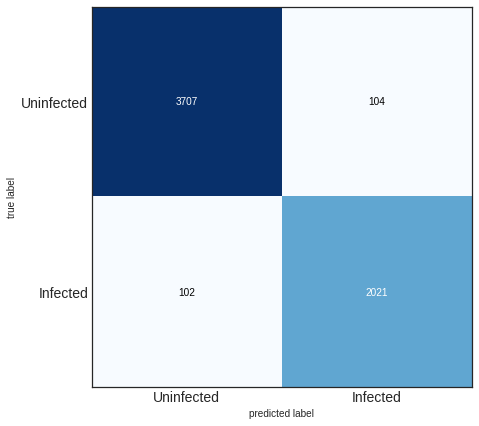

In [0]:
xgboost_yhat = xgboost.predict(test_features)

cm  = confusion_matrix(y_test, xgboost_yhat)
plt.figure()
plot_confusion_matrix(cm,figsize=(7, 7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Uninfected', 'Infected'], fontsize=14)
plt.yticks(range(2), ['Uninfected', 'Infected'], fontsize=14)
plt.show()

In [0]:
TN, FP, FN, TP = cm.ravel()
PRE = TP / (TP+FP)
REC = TP/ (TP+FN)

print("Recall of the model is:  {:.2f}".format(REC))
print("Precision of the model is: {:.2f}".format(PRE))

Recall of the model is:  0.95
Precision of the model is: 0.95
